In [1]:
from gnn_tracking.utils.graph_masks import edge_subgraph

print("hw")

hw


In [2]:
# from importlib import reload
# import gnn_tracking_hpo
# reload(gnn_tracking_hpo)

from gnn_tracking_hpo.util.paths import add_scripts_path
from gnn_tracking_hpo.util.paths import find_checkpoint, get_config

In [3]:

add_scripts_path()

In [4]:

from tune_ec import ECTrainable


In [5]:
d = "ec"
hash = "a94b24d1"
checkpoint_path = find_checkpoint(d, hash)
config = get_config(d, hash)
config.update({"n_graphs_train": 1, "n_graphs_val": 100, "n_graphs_test": 1})
trainable = ECTrainable(config)
trainable.load_checkpoint(checkpoint_path, device="cpu")

[19:36:36 gnnt_hpo] DEBUG: Loading config from /home/kl5675/ray_results/ec/ECTrainable_a94b24d1_1_val_batch_size=5,adam_amsgrad=False,adam_beta1=0.9000,adam_beta2=0.9990,adam_eps=0.0000,adam_weight_decay=0_2023-04-12_22-10-45/params.json
[19:36:37 gnnt_hpo] INFO: I'm running on a node with job ID=46961762
[19:36:37 gnnt_hpo] WARNING: Dispatcher ID was not set. This should be set by the dispatcher as a class attribute to the trainable.
[19:36:37 gnnt_hpo] INFO: The ID of my dispatcher is 0
[19:36:37 SlurmControl] DEBUG: Refreshing control config from /home/kl5675/ray_slurm_control.yaml
[19:36:37 gnnt_hpo] DEBUG: Got config
┌──────────────────────────────────────┬──────────────────────────────────────────┐
│ _val_batch_size                      │ 5                                        │
│ adam_amsgrad                         │ False                                    │
│ adam_beta1                           │ 0.9                                      │
│ adam_beta2                      

In [6]:
from gnn_tracking.training.tcn_trainer import TCNTrainer

trainer: TCNTrainer = trainable.trainer

In [10]:
from torch_geometric.utils import index_to_mask
import torch

trainer.model.eval()

sel = 3
with torch.no_grad():
    loader = trainer.val_loader
    for idx, data in enumerate(loader):
        if idx < sel:
            continue
        model_output = trainer.evaluate_model(data, mask_pids_reco=False)
        # edge_mask = (data.edge_weights > self.threshold).squeeze()
        # data = edge_subgraph(data, edge_mask)
        # connected_nodes = data.edge_index.flatten().unique()
        # hit_mask = index_to_mask(connected_nodes, size=data.num_nodes)
        if idx == sel:
            break

/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/scratch/gpfs/kl5675/micromamba/envs/gnn/lib/python3.10/

In [11]:
import numpy as np


In [12]:
w = model_output["w"]

In [13]:
edge_index = model_output["edge_index"]

In [14]:
from gnn_tracking.metrics.losses import falsify_low_pt_edges

fixed_y = falsify_low_pt_edges(y=model_output["y"], edge_index=edge_index, pt=model_output["pt"], pt_thld=0.9)

In [15]:
from gnn_tracking.metrics.binary_classification import BinaryClassificationStats

In [16]:
from torch import Tensor as T

def get_edge_mask_from_node_mask(node_mask: T, edge_index: T) -> T:
    return node_mask[edge_index[0].long()] & node_mask[edge_index[1].long()]


In [17]:
# from gnn_tracking.utils.graph_masks import get_edge_mask_from_node_mask


def get_n_unconnected(
    pts: torch.Tensor, edge_index: torch.Tensor, pt_thld=0.
) -> int:
    mask = pts > pt_thld
    n_nodes = mask.sum()
    node_count_indices = torch.unique(
        edge_index[:, get_edge_mask_from_node_mask(mask, edge_index)].flatten()
    )
    return n_nodes - len(node_count_indices)

In [18]:
get_n_unconnected(data.pt, data.edge_index[:, w > 0.5], 0.9) / (data.pt > 0.9).sum()

tensor(0.1439)

In [19]:
thlds = np.linspace(0, 0.4, 20)
f = [get_n_unconnected(data.pt, edge_index[:, w>thld]) / len(data.x) for thld in thlds]
f5 = [get_n_unconnected(data.pt, edge_index[:, w>thld], 0.5) / (data.pt > 0.5).sum() for thld in thlds]
f9 = [get_n_unconnected(data.pt, edge_index[:, w>thld], 0.9) / (data.pt > 0.9).sum() for thld in thlds]
f15 = [get_n_unconnected(data.pt, edge_index[:, w>thld], 1.5) / (data.pt > 1.5).sum() for thld in thlds]


def getter(bcs):
    # return (bcs.TP + bcs.FP)/len(bcs._y), bcs.TPR, bcs.TNR
    return bcs.TPR, bcs.FPR

items = np.array([getter(BinaryClassificationStats(output=w, y=fixed_y.long(), thld=thld)) for thld in thlds]).T

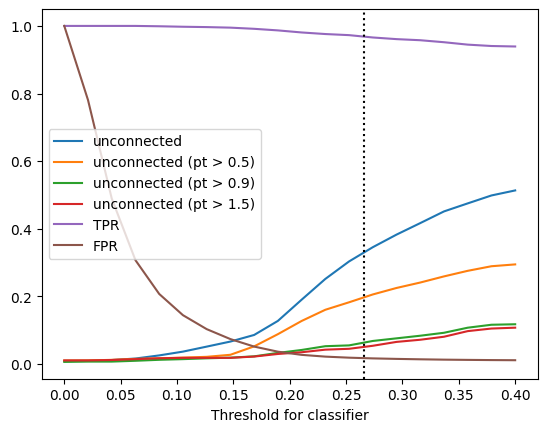

In [20]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(thlds, f, label="unconnected")
ax.plot(thlds, f5, label="unconnected (pt > 0.5)")
ax.plot(thlds, f9, label="unconnected (pt > 0.9)")
ax.plot(thlds, f15, label="unconnected (pt > 1.5)")
ax.plot(thlds, items[0], label="TPR")
ax.plot(thlds, items[1], label="FPR")
ax.set_xlabel("Threshold for classifier")
ax.axvline(0.266, color="k", ls=":")
ax.legend()

In [23]:
thld = 0.266
get_n_unconnected(data.pt, edge_index[:, w>0.266]) / len(data.x), get_n_unconnected(data.pt, edge_index[:, w>thld], 0.9) / (data.pt > 0.9).sum()

(tensor(0.3319), tensor(0.0654))